In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ete3 import NCBITaxa
from tqdm.notebook import tqdm
from Bio import SeqIO
import re
import gzip


In [282]:
proj_dir="/master/nplatt/pathogen_probes/"
os.chdir(proj_dir)

## generate and update an ncbi taxonomy

In [3]:
ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

Updating taxdump.tar.gz from NCBI FTP site (via HTTP)...
Done. Parsing...


Loading node names...
2373905 names loaded.
256152 synonyms loaded.
Loading nodes...
2373905 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /master/nplatt/.etetoolkit/taxa.sqlite ...
 2373000 generating entries... generating entries... 
Uploading to /master/nplatt/.etetoolkit/taxa.sqlite


Inserting synonyms:      20000 

Inserting synonyms:      255000 

Inserting taxids:       15000  

Inserting taxids:       2370000 

## get sample info

In [4]:
samples_df=pd.read_csv("{}/data/19047-41/19047-41-sample_key.csv".format(proj_dir))

## Process reads with snakemake

In [ ]:
%%bash

snakemake \
   --use-conda \
   --cluster 'qsub -V -cwd -S /bin/bash -pe smp {threads} -o {log}.log -j y -q all.q' \
   --jobs 20 \
   --latency-wait 200 \
   --rerun-incomplete \
   --keep-going \
   --snake code/process_seq_data.snake 

In [5]:
os.chdir("{}/results/19047-41/kraken".format(proj_dir))

In [ ]:
%%bash

#make the kraken files comma seperated and get rid of the spaces
cd pathodb_results

for i in $(ls *.tbl); do 
    sed 's/\t/,/g' $i | sed 's/  \{1,\}//g'>pathodb_results/$i
done



## Create a database from kraken files

In [6]:
conf_level = 0.1

### combine raw kraken output

In [108]:
kraken_csvs=glob.glob('pathodb_results/*_pathodb_kraken_report_conf{}.tbl'.format(conf_level))

kraken_columns=["root_perc_frags", "root_num_frags", "taxon_num_frags", "rank", "ncbi_taxa_id", "sci_name"]

df=pd.DataFrame()

for csv in kraken_csvs:
    
    #get sample name
    sample=csv.split("/")[1].replace("_pathodb_kraken_report_conf{}.tbl".format(conf_level), "")
    #open file
    sub_df=pd.read_csv(csv, names=kraken_columns, sep=",", header=None)
    
    #add sample info
    sub_df["sample"]=sample
    
    #add to larger pandas df
    df=pd.concat([df, sub_df])

#get rid of everything that doesn't have reads mapping to it
df = df.loc[df["taxon_num_frags"]>0].reset_index(drop=True)

In [109]:
df

,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample
0,78.05,5585473,5585473,U,0,unclassified,tk52200
1,21.95,1570688,2399,R1,131567,cellular organisms,tk52200
2,21.88,1566018,56088,D,2759,Eukaryota,tk52200
3,21.05,1506118,47887,D1,33154,Opisthokonta,tk52200
4,20.32,1453858,71331,K2,33213,Bilateria,tk52200
...,...,...,...,...,...,...,...
25384,0.00,2,2,S2,192222,Campylobacter jejuni subsp. jejuni NCTC 11168 ...,tk199846
25385,0.00,1,1,S,195,Campylobacter coli,tk199846
25386,0.00,2,1,F,119060,Burkholderiaceae,tk199846
25387,0.00,1,1,S,488729,Burkholderia metallica,tk199846


## add taxon rank info to each kraken entry

In [110]:
#get all ncbi taxanomic ranks:
lineages=[]
uniq_taxa=df["ncbi_taxa_id"].unique()

#make sure they are uniq
ranks=set()

#get the taxanonmic info for each ncbi taxanomic id (including lineage)
for taxon in uniq_taxa:
    try:
        lineage = ncbi.get_lineage(taxon)
        ranks= ranks | set(ncbi.get_rank(lineage).values())
    except:
        continue
        
#manually set major ranks (ex. care about phylum not serogroups)
major_ranks = [ "superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"]
 
#add them to the df
for rank in major_ranks:
    df[rank] = np.nan
    
# add the taxonomic name for each rank column (ex. for mammals class will be "mammalia"
#  should make it easier to sort
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Entries added"):
#for index, row in df.iterrows():

    ncbi_id=row["ncbi_taxa_id"]
    lineage = np.nan
    taxids = np.nan
    ranks = np.nan
    tax = np.nan
    rank = np.nan
    try:
        lineage = ncbi.get_lineage(ncbi_id)
        taxids=ncbi.get_taxid_translator(lineage)
        ranks=ncbi.get_rank(lineage)

        for ncbi_taxa_id in taxids.keys():            
            tax=taxids[ncbi_taxa_id]
            rank=ranks[ncbi_taxa_id]
            if rank in df.columns:
                df.loc[index, rank]=tax
        
    except:
        continue
    
#save to a csv file
df.to_csv("pathodb_kraken_wlineages_conf{}.csv".format(conf_level), sep=',', index=False, header=True)

df

Entries added:   0%|          | 0/25389 [00:00<?, ?it/s]

,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,superkingdom,kingdom,phylum,class,order,family,genus,species
0,78.05,5585473,5585473,U,0,unclassified,tk52200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.95,1570688,2399,R1,131567,cellular organisms,tk52200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21.88,1566018,56088,D,2759,Eukaryota,tk52200,Eukaryota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21.05,1506118,47887,D1,33154,Opisthokonta,tk52200,Eukaryota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20.32,1453858,71331,K2,33213,Bilateria,tk52200,Eukaryota,Metazoa,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25384,0.00,2,2,S2,192222,Campylobacter jejuni subsp. jejuni NCTC 11168 ...,tk199846,Bacteria,NaN,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,Campylobacter jejuni
25385,0.00,1,1,S,195,Campylobacter coli,tk199846,Bacteria,NaN,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,Campylobacter coli
25386,0.00,2,1,F,119060,Burkholderiaceae,tk199846,Bacteria,NaN,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,NaN,NaN
25387,0.00,1,1,S,488729,Burkholderia metallica,tk199846,Bacteria,NaN,Proteobacteria,Betaproteobacteria,Burkholderiales,Burkholderiaceae,Burkholderia,Burkholderia metallica


# Analyze read class db

In [227]:
df=pd.read_csv("pathodb_kraken_wlineages_conf{}.csv".format(conf_level), sep=',')

## filter

In [228]:
taxon_num_frags=df.groupby(["sample"])["taxon_num_frags"].sum()

In [225]:
#this should be saved to a file

np.mean(np.array(taxon_num_frags/1_000_000))

6.678928833333332

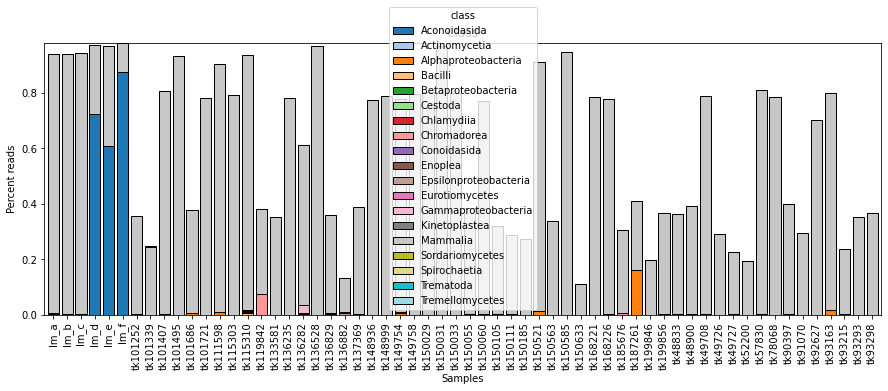

In [229]:
class_agg=df.loc[(df["taxon_num_frags"] > 100)].groupby(['sample','class']).agg({'taxon_num_frags': 'sum'}).reset_index()

class_piv=class_agg.pivot(index="sample", columns="class", values="taxon_num_frags").fillna(0)
#convert to percentages
class_piv = class_piv.div(taxon_num_frags, axis=0)

fig=class_piv.plot(kind='bar', stacked=True, figsize=(15,5), title="Class", ylabel="Percent reads", xlabel="Samples", width=0.8, ec="black", cmap="tab20")
#axes[1].legend(loc=2)  

fig.figure.savefig('class_w_mammal_gt100reads.svg')

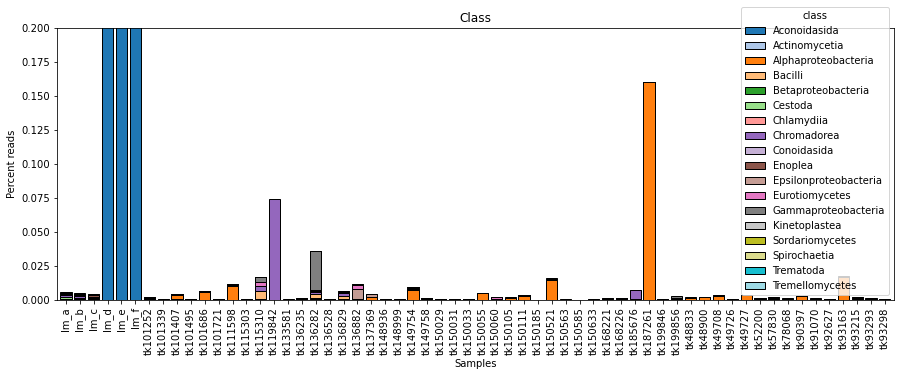

In [230]:
class_agg=df.loc[(df["class"] != "Mammalia") & (df["taxon_num_frags"] > 100)].groupby(['sample','class']).agg({'taxon_num_frags': 'sum'}).reset_index()

class_piv=class_agg.pivot(index="sample", columns="class", values="taxon_num_frags").fillna(0)
#convert to percentages
class_piv = class_piv.div(taxon_num_frags, axis=0)

fig=class_piv.plot(kind='bar', stacked=True, figsize=(15,5), title="Class", ylabel="Percent reads", xlabel="Samples", width=0.8, ec="black", ylim=[0,0.2], colormap="tab20")
#axes[1].legend(loc=2)  

fig.figure.savefig('class_wo_mammal_gt100reads.svg')

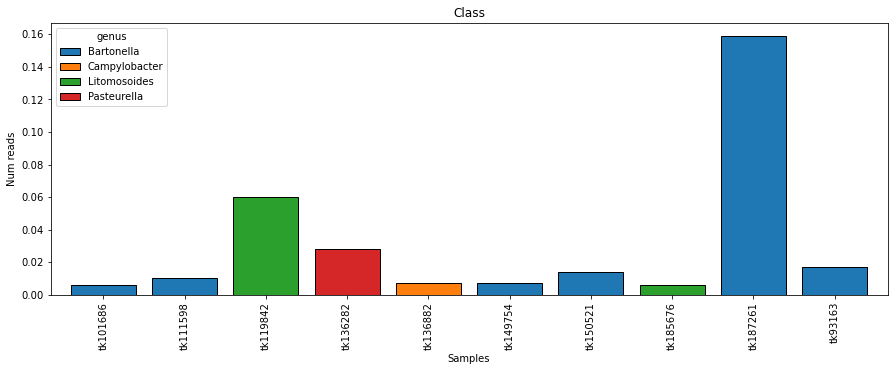

In [263]:
class_agg=df.loc[(df["class"] != "Mammalia") & (df["taxon_num_frags"] > 1000)].groupby(['sample','genus']).agg({'taxon_num_frags': 'sum'}).reset_index()

class_piv=class_agg.pivot(index="sample", columns="genus", values="taxon_num_frags").fillna(0)
#convert to percentages
class_piv = class_piv.div(taxon_num_frags, axis=0)
class_piv.drop(index=["lm_d", "lm_e", "lm_f"], inplace=True)

x=class_piv[class_piv>0.005].dropna(axis=1, how='all').dropna(axis=0, how='all')
fig=x.plot(kind='bar', stacked=True, figsize=(15,5), title="Class", ylabel="Num reads", xlabel="Samples", width=0.8, ec="black")
fig.figure.savefig('class_wo_mammal_gt005perc.svg')

In [222]:
x

class,Aconoidasida,Alphaproteobacteria,Bacilli,Chromadorea,Epsilonproteobacteria,Gammaproteobacteria
sample,,,,,,
lm_d,0.724671,NaN,NaN,NaN,NaN,NaN
lm_e,0.607965,NaN,NaN,NaN,NaN,NaN
lm_f,0.876231,NaN,NaN,NaN,NaN,NaN
tk101686,NaN,0.006093,NaN,NaN,NaN,NaN
tk111598,NaN,0.010410,NaN,NaN,NaN,NaN
tk115310,NaN,NaN,0.005614,NaN,NaN,NaN
tk119842,NaN,NaN,NaN,0.074440,NaN,NaN
tk136282,NaN,NaN,NaN,NaN,NaN,0.02917
tk136882,NaN,NaN,NaN,NaN,0.007447,NaN


In [277]:
df.loc[ (df["sample"] == "tk136282") & (df["genus"] == "Pasteurella")] 

,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,superkingdom,kingdom,phylum,class,order,family,genus,species
21820,2.82,241222,185158,G,745,Pasteurella,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,NaN
21821,0.16,13775,13775,S1,1122935,Pasteurella langaaensis DSM 22999,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella langaaensis
21822,0.14,11682,11682,S,1796644,Pasteurella caecimuris,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella caecimuris
21823,0.10,8756,8756,S,761,Pasteurella testudinis,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella testudinis
21824,0.06,5248,5248,S,754,Pasteurella dagmatis,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella dagmatis
21825,0.05,4662,4662,S,747,Pasteurella multocida,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella multocida
21826,0.05,4337,4337,S,2558280,Pasteurella sp. WM03,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella sp. WM03
21827,0.04,3685,3685,S1,1095749,Pasteurella bettyae CCUG 2042,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella bettyae
21828,0.04,3570,3570,S,97481,Pasteurella skyensis,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella skyensis
21829,0.00,296,296,S,1071947,Pasteurella oralis,tk136282,Bacteria,NaN,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Pasteurella,Pasteurella oralis


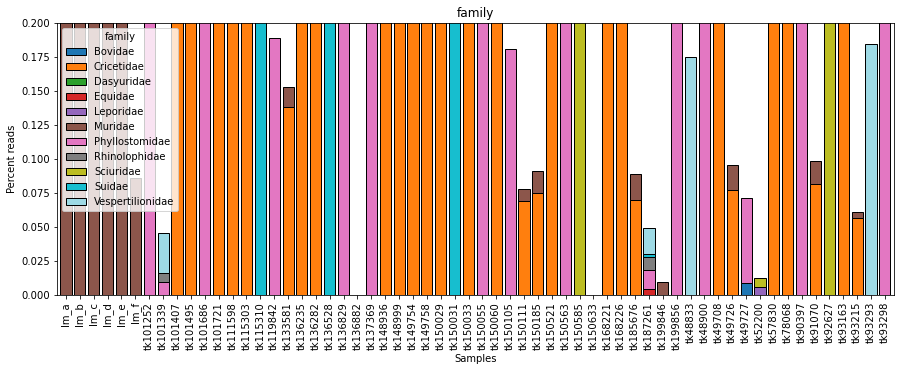

In [182]:
class_agg=df.loc[(df["class"] == "Mammalia") & (df["taxon_num_frags"] > 25_000)].groupby(['sample','family']).agg({'taxon_num_frags': 'sum'}).reset_index()

class_piv=class_agg.pivot(index="sample", columns="family", values="taxon_num_frags").fillna(0)
#convert to percentages
class_piv = class_piv.div(taxon_num_frags, axis=0)

fig=class_piv.plot(kind='bar', stacked=True, figsize=(15,5), title="family", ylabel="Percent reads", xlabel="Samples", width=0.8, ec="black", ylim=[0,0.2], colormap="tab20")
#axes[1].legend(loc=2)  

fig.figure.savefig('family_mammal_gt10kreads.svg')

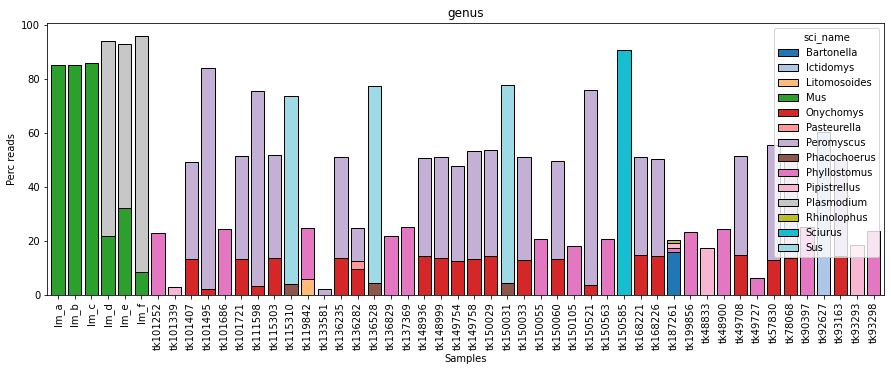

In [24]:
class_agg=df.loc[(df["class"] == "Mammalia") & (df["taxon_num_frags"] > 1_000)].groupby(['sample','family']).agg({'taxon_num_frags': 'sum'}).reset_index()

class_piv=class_agg.pivot(index="sample", columns="family", values="taxon_num_frags").fillna(0)
#convert to percentages
class_piv = class_piv.div(taxon_num_frags, axis=0)

fig=class_piv.plot(kind='bar', stacked=True, figsize=(15,5), title="Family", ylabel="Percent reads", xlabel="Samples", width=0.8, ec="black", ylim=[0,0.2], colormap="tab20")
#axes[1].legend(loc=2)  

#fig.figure.savefig('family_mamal_gt10kreads.svg')

## heatmap

convert the indiv. read classification data to a single data frame that gives reads counts per taxon

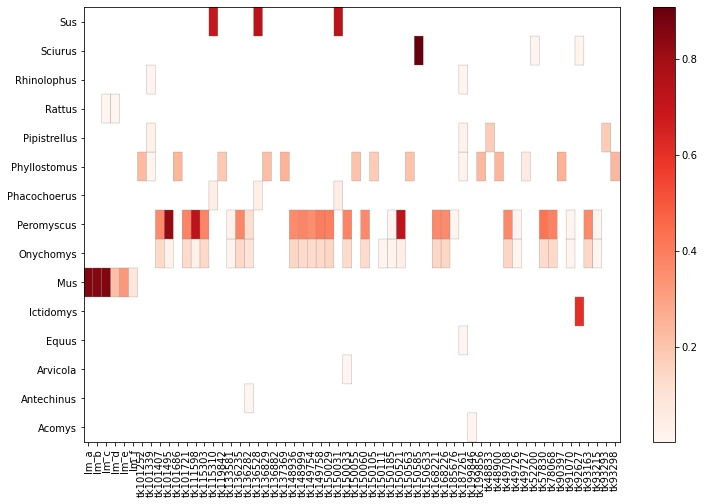

In [221]:
class_agg=df.loc[(df["class"] == "Mammalia") & (df["taxon_num_frags"] > 25_000)].groupby(['sample','genus']).agg({'taxon_num_frags': 'sum'}).reset_index()

class_piv=class_agg.pivot(index="sample", columns="genus", values="taxon_num_frags").fillna(0)
#convert to percentages
class_piv = class_piv.div(taxon_num_frags, axis=0)
class_piv.replace(0, np.nan, inplace=True)


plt.figure(figsize=(12,8))
plt.pcolor(class_piv.T, cmap="Reds", edgecolor='grey')
plt.colorbar()
plt.yticks(np.arange(0.5, len(class_piv.columns), 1), class_piv.columns)
plt.xticks(np.arange(0.5, len(class_piv.index), 1), class_piv.index, rotation='vertical')
plt.savefig('heatmap_genus_gt25k_mammals.svg', dpi=300, facecolor="white")
plt.show()


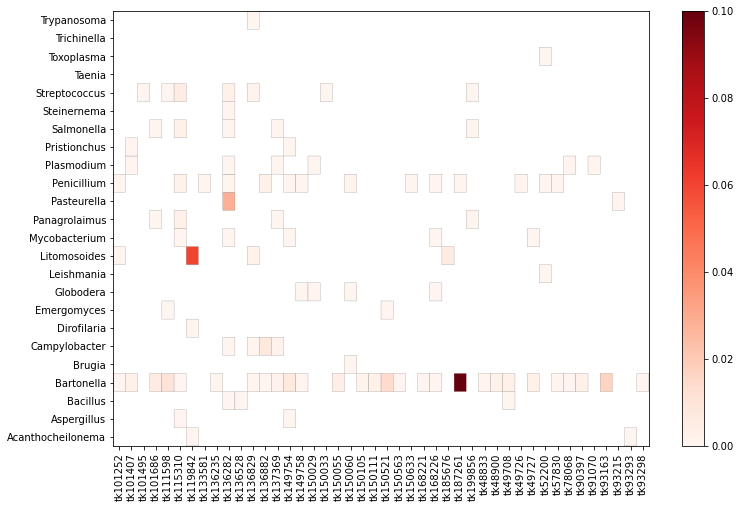

In [278]:
class_agg=df.loc[(df["class"] != "Mammalia") & (df["taxon_num_frags"] > 1000)].groupby(['sample','genus']).agg({'taxon_num_frags': 'sum'}).reset_index()
#class_agg=df.loc[(df["class"] != "Mammalia")].groupby(['sample','genus']).agg({'taxon_num_frags': 'sum'}).reset_index()

class_piv=class_agg.pivot(index="sample", columns="genus", values="taxon_num_frags").fillna(0)
#convert to percentages
class_piv = class_piv.div(taxon_num_frags, axis=0)

#drop controls
class_piv=class_piv.drop(labels=["lm_a", "lm_b", "lm_c", "lm_d", "lm_e", "lm_f"]).dropna(axis=1, how='all').dropna(axis=0, how='all')
class_piv.replace(0, np.nan, inplace=True)

plt.figure(figsize=(12,8))
plt.pcolor(class_piv.T, cmap="Reds", edgecolor='grey', vmin=0, vmax=0.1)
plt.colorbar()
plt.yticks(np.arange(0.5, len(class_piv.columns), 1), class_piv.columns)
plt.xticks(np.arange(0.5, len(class_piv.index), 1), class_piv.index, rotation='vertical')
#plt.savefig('heatmap_genus_gt1k_pathogens.svg', dpi=300, facecolor="white")
plt.show()


In [281]:
class_piv["Trichinella"]

sample
tk101252   NaN
tk101407   NaN
tk101495   NaN
tk101686   NaN
tk111598   NaN
tk115310   NaN
tk119842   NaN
tk133581   NaN
tk136235   NaN
tk136282   NaN
tk136528   NaN
tk136829   NaN
tk136882   NaN
tk137369   NaN
tk149754   NaN
tk149758   NaN
tk150029   NaN
tk150033   NaN
tk150055   NaN
tk150060   NaN
tk150105   NaN
tk150111   NaN
tk150521   NaN
tk150563   NaN
tk150633   NaN
tk168221   NaN
tk168226   NaN
tk185676   NaN
tk187261   NaN
tk199856   NaN
tk48833    NaN
tk48900    NaN
tk49708    NaN
tk49726    NaN
tk49727    NaN
tk52200    NaN
tk57830    NaN
tk78068    NaN
tk90397    NaN
tk91070    NaN
tk93163    NaN
tk93215    NaN
tk93293    NaN
tk93298    NaN
Name: Trichinella, dtype: float64

# Next

In [20]:
df.loc[(df["sample"]=="TK25651") & (df["genus"]=="Plasmodium")]


,root_perc_frags,root_num_frags,taxon_num_frags,rank,ncbi_taxa_id,sci_name,sample,lineage,superkingdom,kingdom,phylum,class,order,family,genus,species
103335,21.95,1028637,126,G,5820,Plasmodium,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,NaN
103336,18.93,887345,542315,G1,418107,Plasmodium (Laverania),TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,NaN
103337,2.89,135526,0,S,5833,Plasmodium falciparum,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
103338,2.89,135526,135526,S1,36329,Plasmodium falciparum 3D7,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
103339,2.12,99408,99408,S,5854,Plasmodium reichenowi,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium reichenowi
103340,0.96,44771,44771,S,880534,Plasmodium sp. gorilla clade G1,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G1
103341,0.92,42988,42988,S,880536,Plasmodium sp. gorilla clade G3,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G3
103342,0.48,22310,22310,S,880535,Plasmodium sp. gorilla clade G2,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. gorilla clade G2
103343,0.00,21,21,S,720590,Plasmodium sp. DRC-Itaito,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium sp. DRC-Itaito
103344,0.00,6,6,S,647221,Plasmodium gaboni,TK25651,"root, Eukaryota, Apicomplexa, Haemosporida, Pl...",Eukaryota,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium gaboni


In [130]:
sample = "TK25651_Exp5_42_P5"

r1_file="results/filter_reads/{}_filtered_R1_PE.fastq.gz".format(sample)
r2_file="results/filter_reads/{}_filtered_R2_PE.fastq.gz".format(sample)
results_tbl="results/kraken2/{}_kraken_results.tbl".format(sample)

#mammalia
target_taxa="Plasmodium"



In [122]:
#count number of lines for analyses
with open(results_tbl, 'r') as f:
    n_lines=len(f.readlines())
    
#
with open(results_tbl, 'r') as in_f:
    with open("outfile.txt", 'w') as out_f:
        for entry in tqdm(in_f, total=n_lines):
            if "Plasmodium" in entry:
                out_f.write("{}\n".format(entry.split("\t")[1]))

#extract with seqtk
! seqtk subseq results/filter_reads/TK25651_Exp5_42_P5_filtered_R1_PE.fastq.gz outfile.txt >test.fq


  0%|          | 0/4687054 [00:00<?, ?it/s]

In [142]:
with gzip.open(r1_file, "rt") as f:
    n_fq_seqs=len(f.readlines())/4
    
n_fq_seqs

4687054.0

In [157]:
target_reads=[]
r1_read_ids=read_ids
records=[]
with gzip.open(r1_file, "rt") as f:
    for record in tqdm(SeqIO.parse(f, "fastq"), total=n_fq_seqs):
        records.append(record)
        
        
        
#         if record.id in r1_read_ids:
#             target_reads.append(record)
#             r1_read_ids.remove(record.id)

  0%|          | 0/4687054.0 [00:00<?, ?it/s]

In [156]:
len(read_ids)

1026984

In [87]:
ncbi.get_taxid_translator([2])

{2: 'Bacteria'}

In [86]:
taxid

0